# Multiclass semantic segmentation using DeepLabV3+

**Author:** [Soumik Rakshit](http://github.com/soumik12345)<br>
**Date created:** 2021/08/31<br>
**Last modified:** 2024/01/05<br>
**Description:** Implement DeepLabV3+ architecture for Multi-class Semantic Segmentation.

## Introduction

Semantic segmentation, with the goal to assign semantic labels to every pixel in an image,
is an essential computer vision task. In this example, we implement
the **DeepLabV3+** model for multi-class semantic segmentation, a fully-convolutional
architecture that performs well on semantic segmentation benchmarks.

### References:

- [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1802.02611)
- [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)
- [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915)

## Downloading the data

We will use the [Crowd Instance-level Human Parsing Dataset](https://arxiv.org/abs/1811.12596)
for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images.
Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification.
This dataset can be used for the "human part segmentation" task.

In [1]:

import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [2]:
!gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:38<00:00, 75.3MB/s]


In [8]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import ops
from keras.optimizers.schedules import ExponentialDecay # Import ExponentialDecay

## Creating a TensorFlow Dataset

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using
a smaller subset of 200 images for training our model in this example.

In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


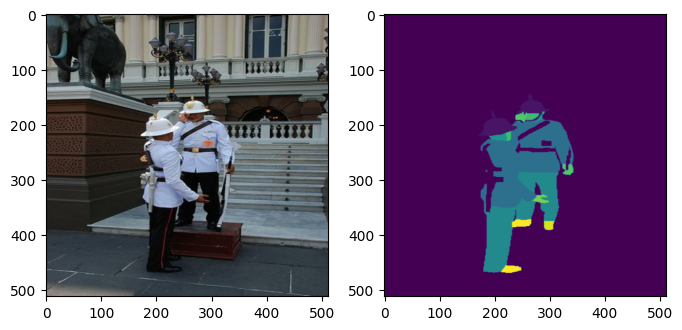

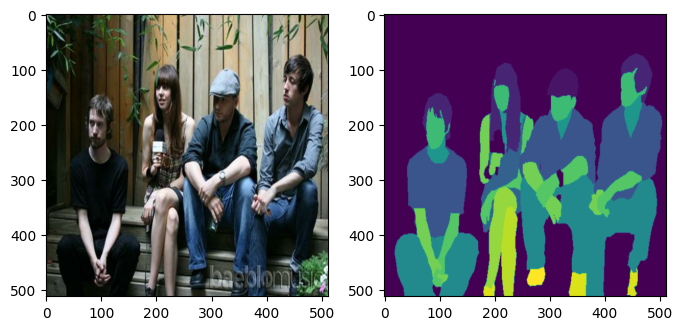

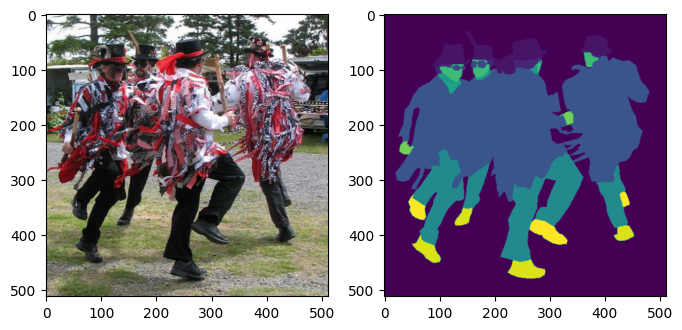

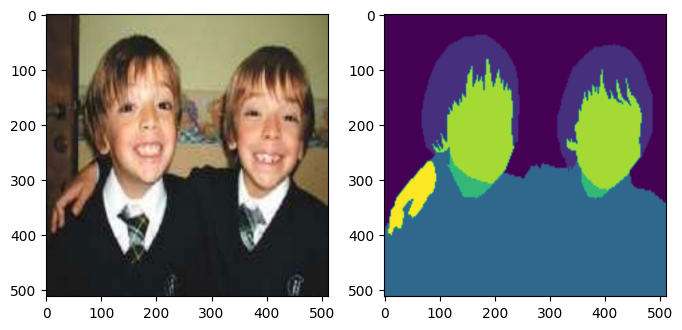

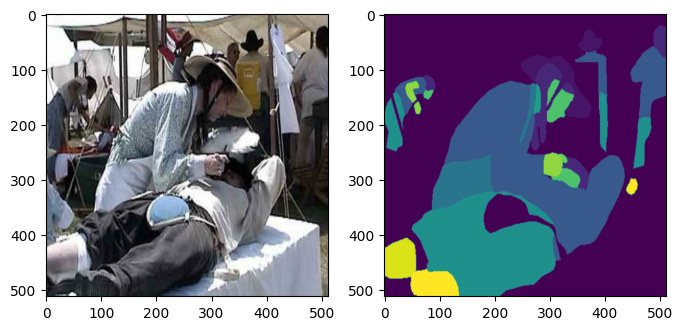

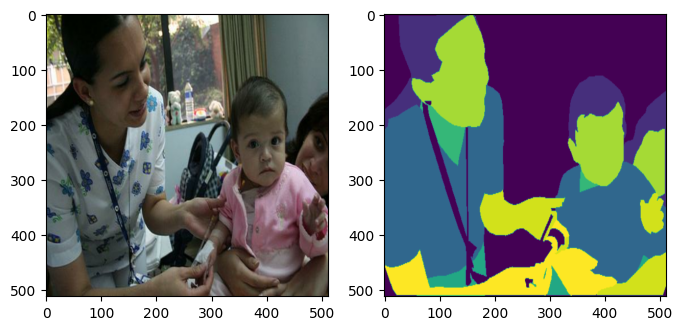

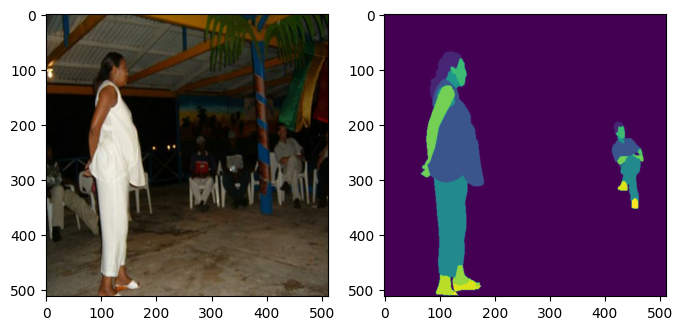

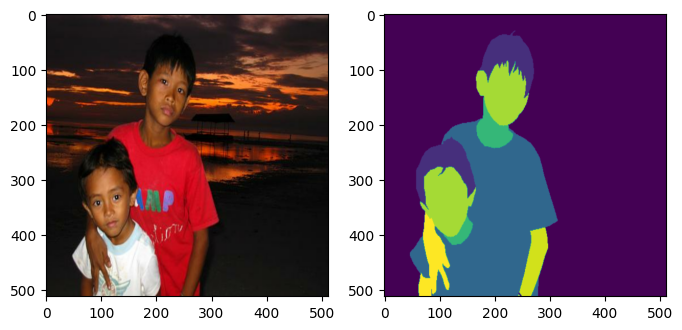

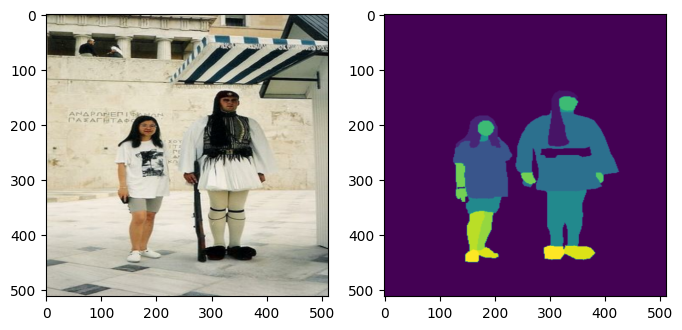

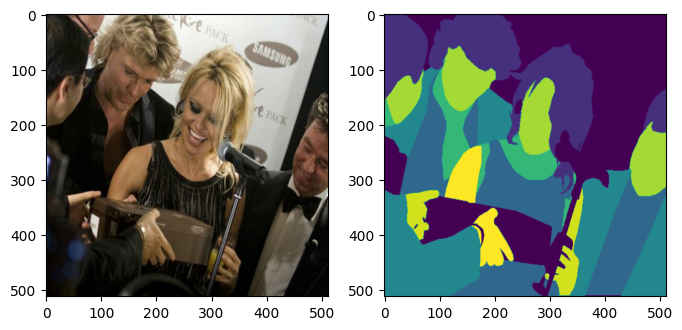

In [4]:
for i in range(10):
  _, ax = plt.subplots(1,2, figsize=(8, 4))
  example_image, example_mask = load_data(train_images[i], train_masks[i])
  ax[0].imshow(example_image.numpy().astype(np.uint8))
  ax[1].imshow(example_mask)
  plt.show()

## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [5]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [6]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 512, 512)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 512, 512)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 512, 512)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 512, 512,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 512,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c

 Total params: 11,857,236 (45.23 MB)

 Trainable params: 11,824,500 (45.11 MB)

 Non-trainable params: 32,736 (127.88 KB)

## Training

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 217s 507ms/step - accuracy: 0.5712 - loss: 1.6679 - val_accuracy: 0.7353 - val_loss: 1.0001
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 468ms/step - accuracy: 0.7719 - loss: 0.7654 - val_accuracy: 0.7685 - val_loss: 0.7289
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 467ms/step - accuracy: 0.8244 - loss: 0.5782 - val_accuracy: 0.7671 - val_loss: 0.8265
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 467ms/step - accuracy: 0.8643 - loss: 0.4539 - val_accuracy: 0.7714 - val_loss: 0.8414
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 467ms/step - accuracy: 0.8842 - loss: 0.3893 - val_accuracy: 0.7694 - val_loss: 0.9607
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 468ms/step - accuracy: 0.8976 - loss: 0.3447 - val_accuracy: 0.8003 - val_loss: 0.7552
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 467ms/step - accuracy: 0.9140 - loss: 0.2959 - val_accuracy: 0.7974 - val_loss: 0.8036
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 466ms/step - accuracy: 0.9247 -

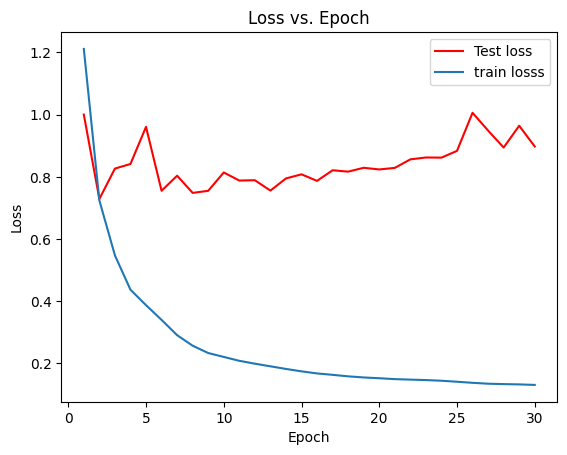

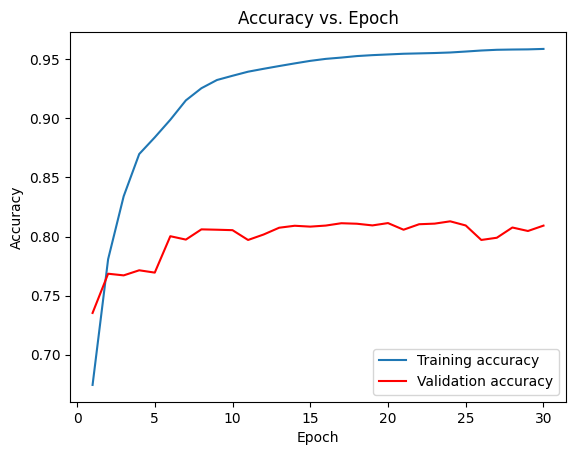

In [10]:
epochs = 30
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9
)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule, weight_decay=0.01),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'train losss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.show()

def plot_accuracy(history):
    x = list(range(1, len(history.history['accuracy']) + 1))
    plt.plot(x, history.history['accuracy'], label = 'Training accuracy')
    plt.plot(x, history.history['val_accuracy'], color = 'red', label = 'Validation accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.show()

plot_loss(history)
plot_accuracy(history)

## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [11]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )


### Inference on Train Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


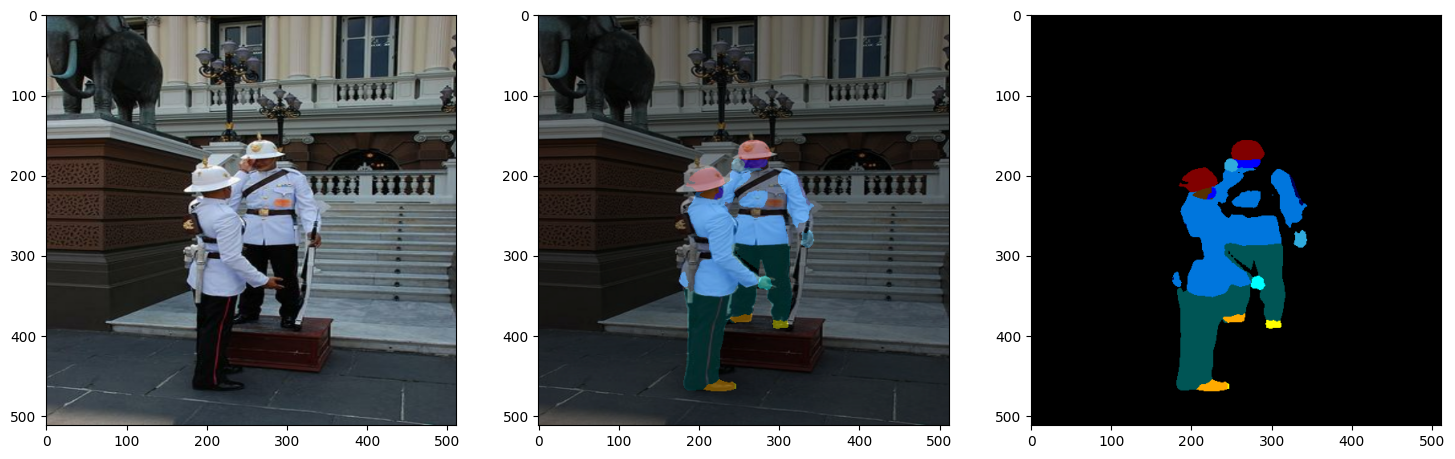

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


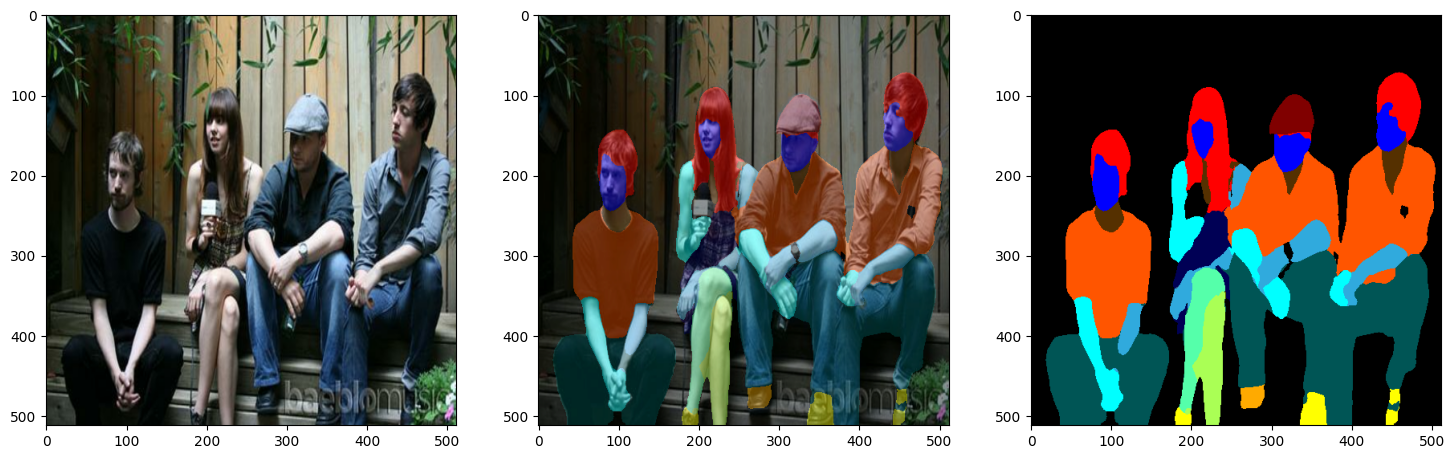

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


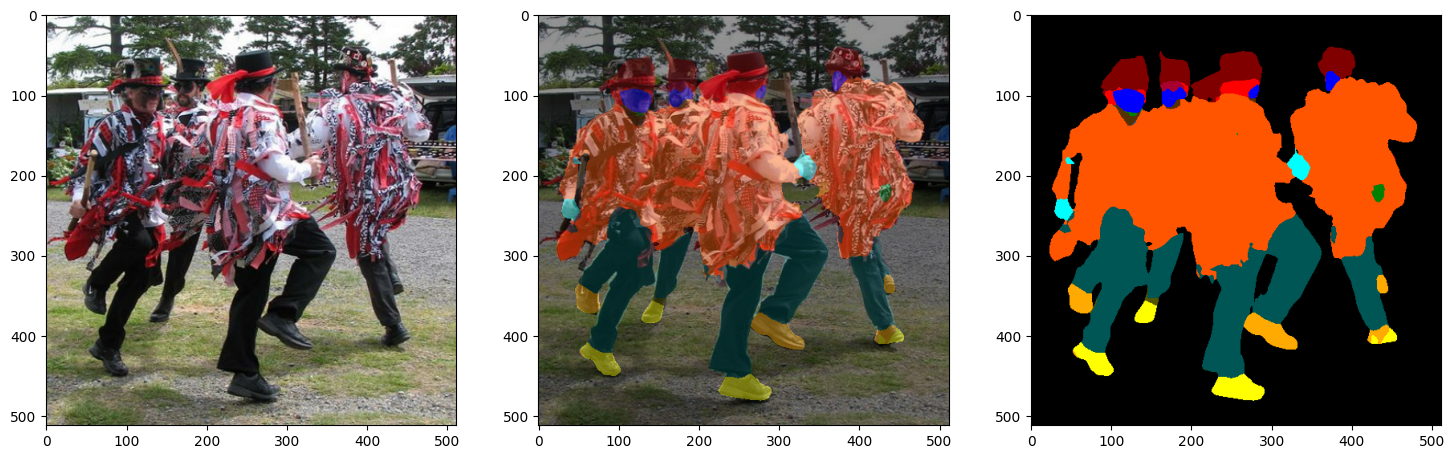

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


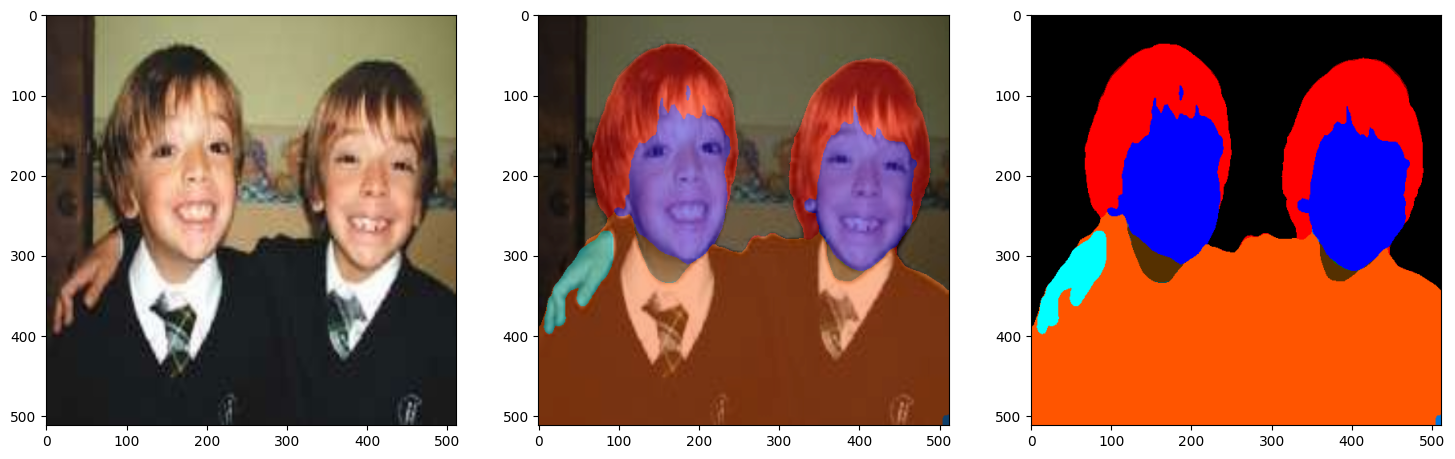

In [12]:
plot_predictions(train_images[:4], colormap, model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Average error =  0.046583883


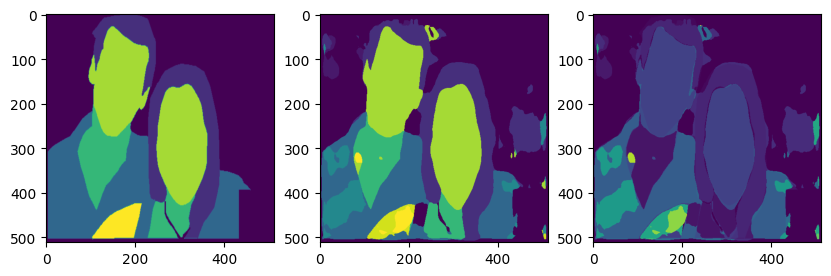

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Average error =  0.06712838


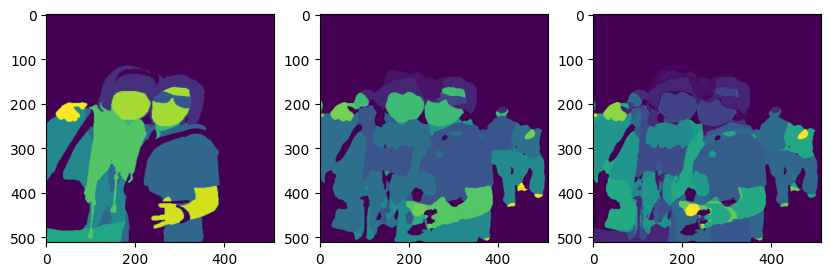

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Average error =  0.055729162


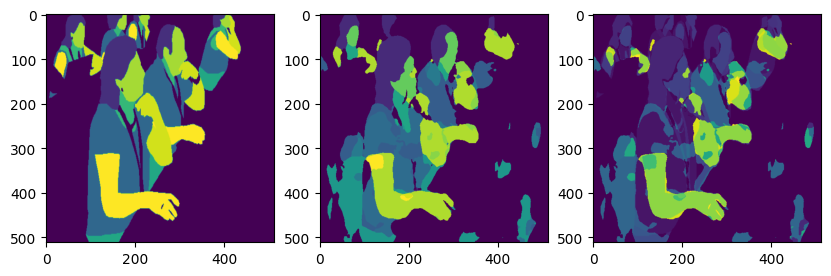

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Average error =  0.039468624


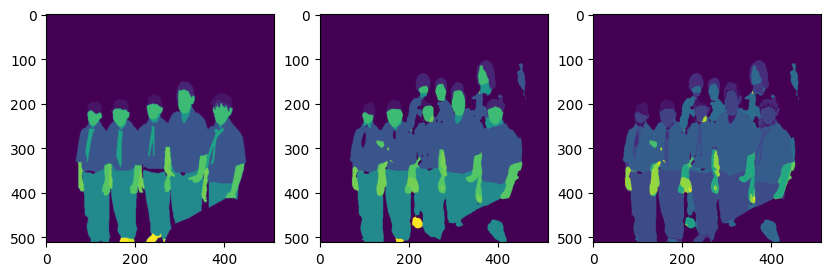

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Average error =  0.05709223


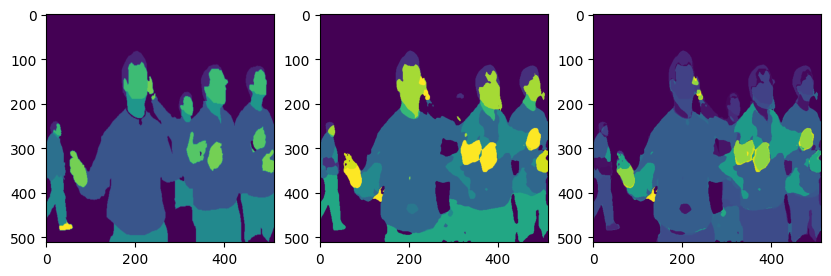

In [13]:
for i in range(5):
  val_image, val_mask = load_data(val_images[i], val_masks[i])
  predicted_mask = infer(model, val_image)

  _ , ax = plt.subplots(1,3, figsize=(10, 3))
  ax[0].imshow(val_mask)
  ax[1].imshow(predicted_mask)

  predicted_mask_gray = cv2.cvtColor(
                                     decode_segmentation_masks(predicted_mask, colormap, 20),
                                      cv2.COLOR_BGR2GRAY
                                     )
  mask_diff = np.abs(np.subtract(val_mask.numpy().reshape((512,512)),
                           predicted_mask_gray.reshape((512,512))))
  ax[2].imshow(mask_diff)
  print('Average error = ', str(np.divide(np.sum(mask_diff), 512*512*255)))
  plt.show()

### Inference on Validation Images

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/deeplabv3p-resnet50)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/Human-Part-Segmentation).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


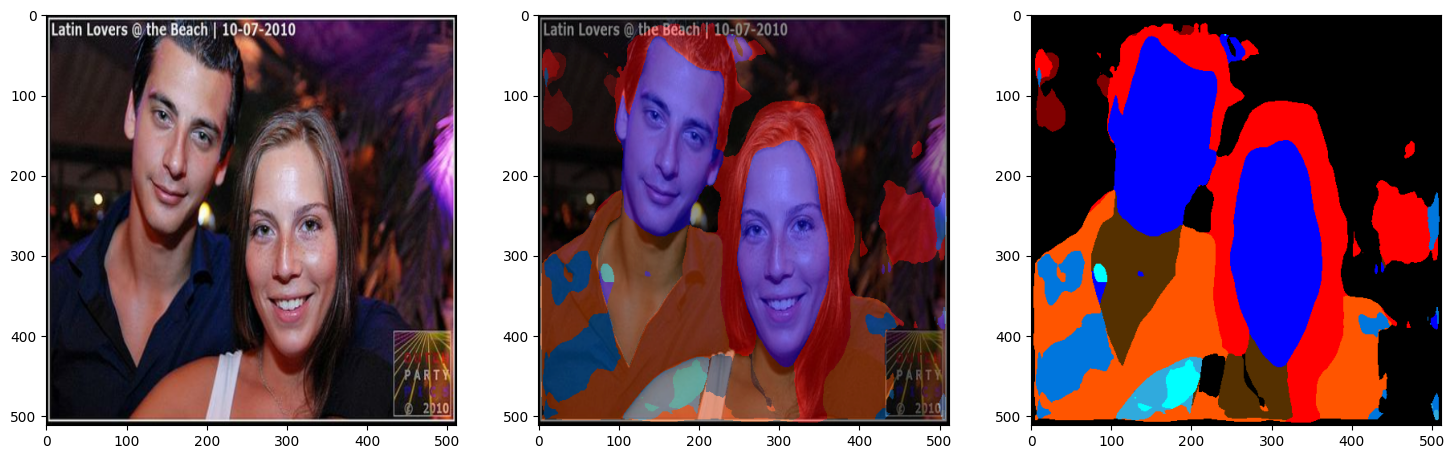

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


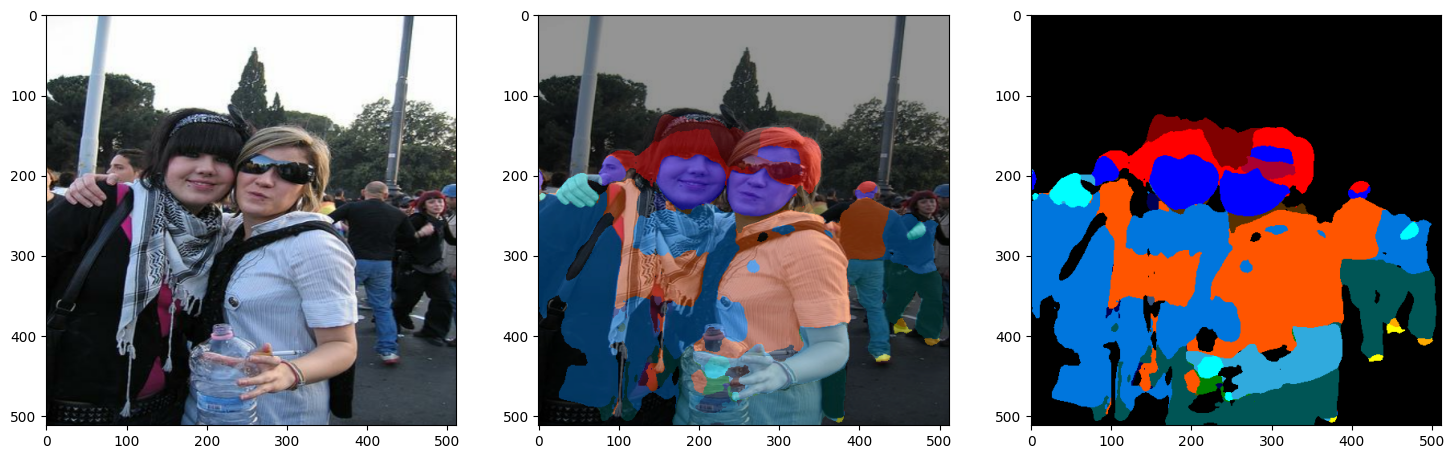

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


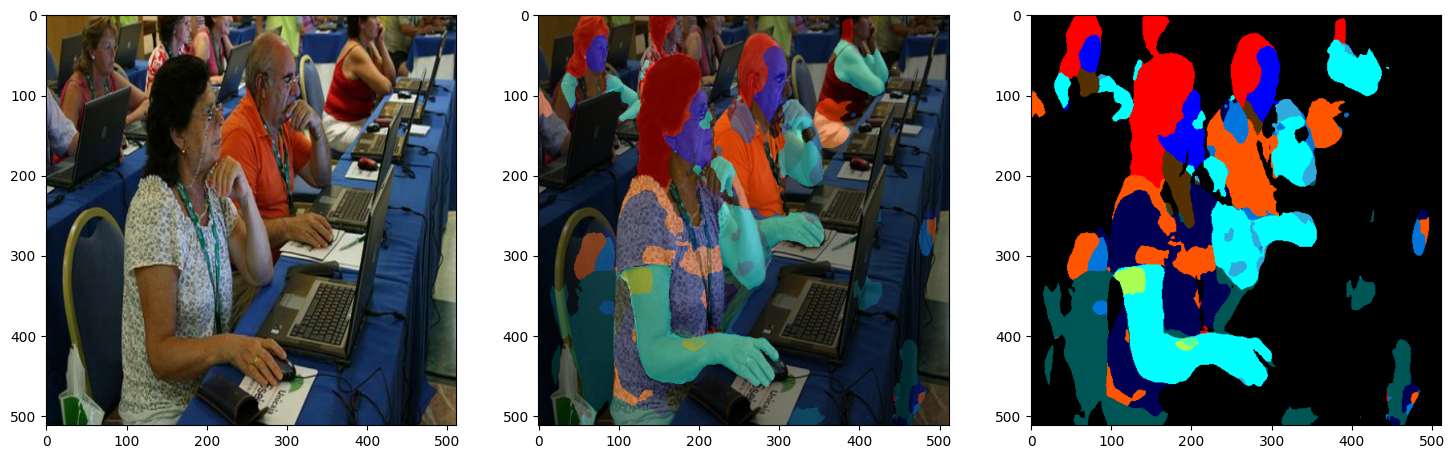

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


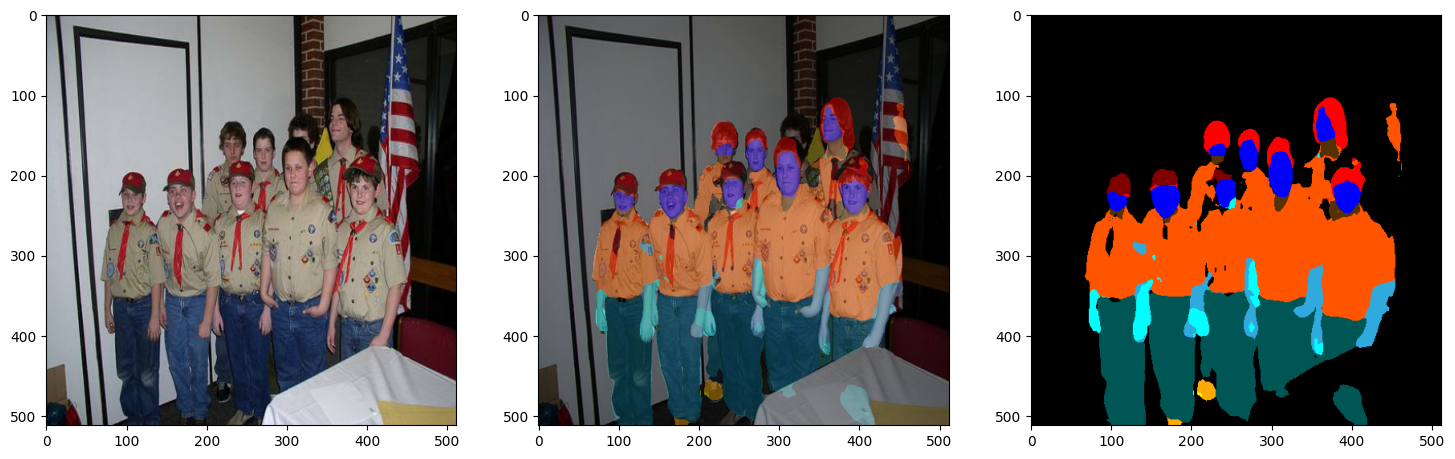

In [14]:
plot_predictions(val_images[:4], colormap, model=model)